## Training process for ECD507 Senior Capstone Project - F1Tenth ML Based Autonomous Race Car
### Contributors - Charles Hodgins, Rishabh Hegde, Dylan DiGiacomo, and Andrew Meccariello

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import ast

In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


In [4]:
class DrivingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx,1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200, 66))  # Resize using OpenCV
        image = image / 255.0  # Normalize pixel values to [0,1]
        image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        steering_angle = float(self.data.iloc[idx, 3])
        throttle = float(self.data.iloc[idx, 4])
        lidar = torch.tensor(ast.literal_eval(self.data.iloc[idx, 2]))
               
        return image, lidar, torch.tensor([steering_angle, throttle], dtype=torch.float32)


In [5]:
df = pd.read_csv('/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log.csv')
print(len(df))

112613


/home/ecd507/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:

def filter_chunk(df):
    global first_chunk
    print(first_chunk)
    print(f"Initial size: {len(df)}")

    def is_valid_image(img_path):
        return os.path.exists(img_path) and cv2.imread(img_path) is not None
    
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    before_throttle = len(df)
    df = df[df["throttle"] != 0 ]
    print(f"Filtered throttle: {before_throttle - len(df)} rows removed")

    before_lidar = len(df)
    df = df[df["lidar_list"] != ""]
    df = df[pd.notna(df["lidar_list"])]
    print(f"Filtered lidar: {before_lidar - len(df)} rows removed")

    before_images = len(df)
    df["image_path"] = df["image_path"].str.strip()
    df = df[df["image_path"] != ""]
    df_filtered = df[df["image_path"].apply(is_valid_image)]
    print(f"Filtered images: {before_images - len(df_filtered)} rows removed")

    print(f"Final size: {len(df_filtered)}")
    
    print(len(df_filtered))
    
    if first_chunk:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='w', index=False, header=True)
        first_chunk = False
    else:
        df_filtered.to_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv", mode='a', index=False, header=False)


    # Save the cleaned dataset


    
first_chunk = True

for chunk in pd.read_csv("/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log.csv",chunksize = 10000):
    print('loaded chunk')
    filter_chunk(chunk)
    # print(chunk.head())
    del chunk
    
print('done')

loaded chunk
True
Initial size: 10000
Filtered throttle: 1009 rows removed
Filtered lidar: 12 rows removed
Filtered images: 0 rows removed
Final size: 8979
8979
loaded chunk
False
Initial size: 10000
Filtered throttle: 1331 rows removed
Filtered lidar: 0 rows removed
Filtered images: 0 rows removed
Final size: 8669
8669
loaded chunk
False
Initial size: 10000
Filtered throttle: 371 rows removed
Filtered lidar: 0 rows removed
Filtered images: 0 rows removed
Final size: 9629
9629
loaded chunk
False
Initial size: 10000
Filtered throttle: 773 rows removed
Filtered lidar: 0 rows removed
Filtered images: 0 rows removed
Final size: 9227
9227
loaded chunk
False
Initial size: 10000
Filtered throttle: 2644 rows removed
Filtered lidar: 0 rows removed
Filtered images: 0 rows removed
Final size: 7356
7356
loaded chunk
False
Initial size: 10000
Filtered throttle: 1082 rows removed
Filtered lidar: 0 rows removed
Filtered images: 0 rows removed
Final size: 8918
8918
loaded chunk
False
Initial size: 523

In [8]:

dataset = DrivingDataset('/media/ecd507/JetsonOrinNano/home/ecd507/training/data/driving_log2.csv')
print(len(dataset))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

57160


In [ ]:
img,lidar, label = dataset[20]
print(lidar.shape)


In [9]:
# Define CNN model
class CameraCNNModel(nn.Module):
    def __init__(self):
        super(CameraCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3840, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)  # Output: Steering angle and Throttle
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

import torch.nn.functional as F


class ResNet15(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size = 7, stride = 1, padding = 'same')
        self.conv1_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv4_bn = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv6_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv6_bn = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv7_shortcut = nn.Conv2d(64,128, kernel_size = 2, stride = 2)
        self.conv7_shortcut_bn = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv8_bn = nn.BatchNorm2d(128)

        self.conv9 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv9_bn = nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv10_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv10_bn = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv11_bn = nn.BatchNorm2d(256)
        self.conv11_shortcut = nn.Conv2d(128,256, kernel_size = 2, stride = 2)
        self.conv11_shortcut_bn = nn.BatchNorm2d(256)

        self.conv12 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv12_bn = nn.BatchNorm2d(256)

        self.conv13 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv13_bn = nn.BatchNorm2d(256)

        self.conv14 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv14_bn = nn.BatchNorm2d(256)

        self.FC1 = nn.Linear(256*4*12,2)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv1_maxpool(x)
        x = F.relu(self.conv1_bn(nn.MaxPool2d(kernel_size=3,stride = 2,padding = 1)(x)))

        # first block
        x1 = F.relu(self.conv2_bn(self.conv2(x)))
        x1 = F.relu(self.conv3_bn(self.conv3(x1)))
        x = x1 + x 
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x = x1 + x

        #second block
        x2 = F.relu(self.conv6_bn(self.conv6_maxpool(self.conv6(x))))
        x2 = F.relu(self.conv7_bn(self.conv7(x2)))
        # print(x2.shape)
        # print(self.conv7_shortcut_bn(self.conv7_shortcut(x)).shape)
        x = F.relu(x2 + self.conv7_shortcut_bn(self.conv7_shortcut(x)))
        x2 = F.relu(self.conv8_bn(self.conv8(x)))
        x2 = F.relu(self.conv9_bn(self.conv9(x2)))
        x = x2 + x

        x3 = F.relu(self.conv10_bn(self.conv10_maxpool(self.conv10(x))))
        x3 = F.relu(self.conv11_bn(self.conv11(x3)))
        x = F.relu(self.conv11_shortcut_bn(self.conv11_shortcut(x)))
        x3 = F.relu(self.conv12_bn(self.conv12(x3)))
        x3 = F.relu(self.conv13_bn(self.conv13(x3)))
        x3 = F.relu(self.conv14_bn(self.conv14(x3)))
        # print(x.shape)
        x = x + x3
        

        x = x.view(x.size(0),-1)
        x = self.FC1(x)
        return x


In [ ]:
input("wait for training...")

In [ ]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
print(device)
model = ResNet15().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, )

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images,lidar,targets in dataloader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}')

# Save model
torch.save(model.state_dict(), '/media/ecd507/JetsonOrinNano/home/ecd507/training/model.pth')
print("Model training complete and saved as model.pth")

57160
57159
torch.Size([1, 3, 66, 200])
tensor([ 0.5192, -2.5633])
tensor([[0.6330, 0.5923]], device='cuda:0')


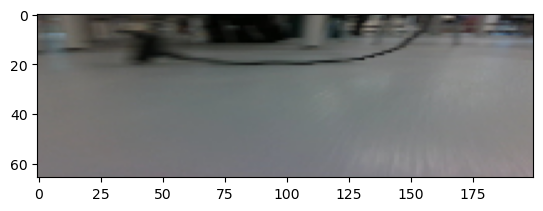

In [16]:
checkpoint = torch.load('/media/ecd507/JetsonOrinNano/home/ecd507/training/model.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
model = ResNet15().to(device)
model.load_state_dict(checkpoint)
model.eval()
print(len(dataset))

idx = len(dataset)-1
print(idx)
img,lidar, label = dataset[idx]
img = img.to(device)
img = img.unsqueeze(0) 
img_ = img.to('cpu')
img_ = np.squeeze(img_)
img_ = np.transpose(img_, (1,2,0))  # Change shape to (C, H, W)
print(img.shape)
plt.imshow(img_)

# print(img_.shape)

with torch.no_grad():
    output = model(img)
plt.imshow(img_)

print(label)
print(output)